# Feature Extraction using CNN

Resnet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import cv2
import os

In [2]:
from google.colab import drive
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/Solar/CNN

/content/drive/MyDrive/Colab Notebooks/Solar/CNN


In [5]:
np.random.seed(42)

In [6]:
#Image path
img_path = '../data/box_img/'

#label
label = pd.read_csv('../data/Standard.csv')['Thickness']

In [7]:
label

0      48.266667
1      47.966667
2      48.166667
3      48.600000
4      59.533333
         ...    
122    84.633333
123    98.366667
124    97.033333
125    96.266667
126    97.766667
Name: Thickness, Length: 127, dtype: float64

In [9]:
device = torch.device('cuda')

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_path, label, transform = None):
        self.img_path = img_path
        self.label = label
        self.transform = transform


    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + 'Cat/' + 'cat_' + str(idx) + '.jpg')
        label = self.label[idx]

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label)

        return img, label

#Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                        std = [0.5, 0.5, 0.5])
])

#Dataset
dataset = CustomDataset(img_path, label, transform = transform)

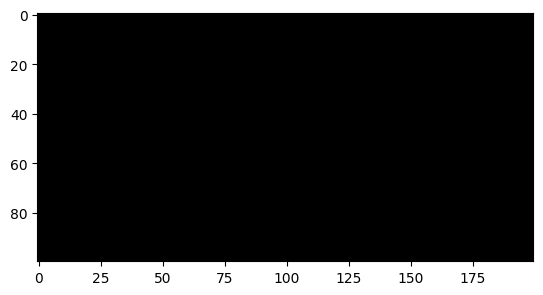

In [12]:
#show image
plt.imshow(dataset[0][0].permute(1, 2, 0))

In [13]:
#split train, test
test_idx = pd.read_csv('../data/test_index.csv')
test_idx = test_idx['test_index'].values
test_idx

array([ 26, 111,  81,  55,  44,  96,  80, 125, 114,  62,  45,   4,  18,
        95,  36,  94,  19, 120,  10,  40,  11,  98, 104,  77,   0,  78,
        68,  69,  12,  42,  31,  27,  24,  93, 110,  91,  15,  76,  22])

In [14]:
test_dataset = torch.utils.data.Subset(dataset, test_idx)
train_dataset = torch.utils.data.Subset(dataset, list(set(range(len(dataset))) - set(test_idx)))

In [15]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [16]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 100, 200])

In [17]:
# ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes = 1):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.make_layer(ResidualBlock, 64, 3, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 4, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 3, stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [21]:
model = ResNet(ResidualBlock)
model = model.to(device)

epoch: 1, train_loss: 6426.3428, test_loss: 8720.2605
epoch: 2, train_loss: 3416.2544, test_loss: 3708.7095
epoch: 3, train_loss: 1032.6744, test_loss: 2294.5264
epoch: 4, train_loss: 165.1953, test_loss: 814.4605
epoch: 5, train_loss: 502.2352, test_loss: 765.6567
epoch: 6, train_loss: 149.7120, test_loss: 1507.0051
epoch: 7, train_loss: 141.3322, test_loss: 2311.0129
epoch: 8, train_loss: 99.8047, test_loss: 2034.2880
epoch: 9, train_loss: 94.9422, test_loss: 1982.7964
epoch: 10, train_loss: 91.5038, test_loss: 1793.4047
epoch: 11, train_loss: 89.3451, test_loss: 1305.7870
epoch: 12, train_loss: 62.1787, test_loss: 621.1221
epoch: 13, train_loss: 74.6303, test_loss: 371.3359
epoch: 14, train_loss: 66.4938, test_loss: 564.9506
epoch: 15, train_loss: 111.5050, test_loss: 1511.7085
epoch: 16, train_loss: 97.6295, test_loss: 256.4590
epoch: 17, train_loss: 78.7616, test_loss: 133.6138
epoch: 18, train_loss: 107.7596, test_loss: 409.3662
epoch: 19, train_loss: 78.5273, test_loss: 810.2985

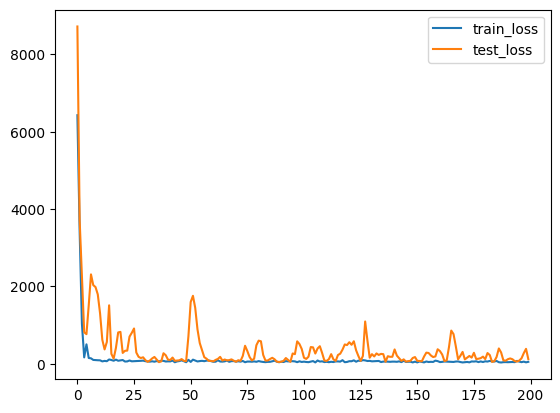

In [22]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0

    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    return train_loss

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0

    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target.float().unsqueeze(1))

        running_loss += loss.item()

    test_loss = running_loss / len(test_loader)

    return test_loss

#Training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

train_loss_list = []
test_loss_list = []

for epoch in range(200):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    print('epoch: {}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch + 1, train_loss, test_loss))

#Plot
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(test_loss_list, label = 'test_loss')
plt.legend()

In [27]:
#Predict
model.eval()
pred = []

for i, (data, target) in enumerate(test_loader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    pred.append(output.detach().cpu().numpy())


pred = np.concatenate(pred, axis = 0)

In [28]:
pred = pd.DataFrame(pred)
pred = pred[0].values
pred

array([ 68.818184,  56.9745  ,  70.679436, 104.19717 ,  99.310715,
        61.852516,  67.23246 ,  88.34803 ,  62.24981 , 109.232864,
        95.12192 ,  62.78641 ,  88.16478 ,  59.118286,  78.389915,
        98.73495 ,  91.447716,  77.87189 ,  61.297314,  79.65259 ,
        45.11614 ,  62.245506,  82.40069 , 145.92697 ,  54.423832,
       116.175674,  93.45906 ,  99.10906 ,  66.56669 ,  82.554405,
        58.852093,  72.43464 ,  65.77598 , 102.29578 ,  95.49396 ,
        92.84837 ,  63.998367, 143.8869  ,  75.67867 ], dtype=float32)

Text(0.5, 1.0, 'RMSE: 9.8673')

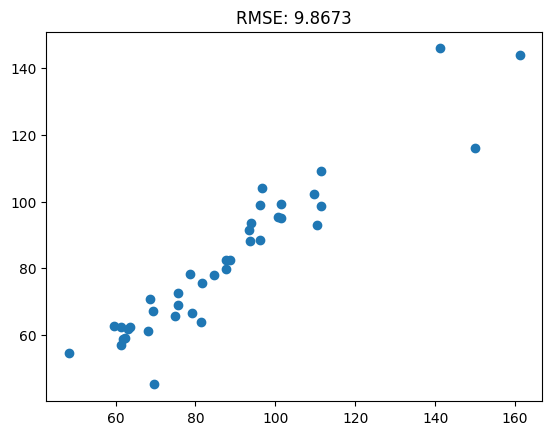

In [29]:
y_test = label[test_idx]
plt.scatter(y_test, pred)
rmse = np.sqrt(np.mean((y_test - pred) ** 2))
plt.title('RMSE: {:.4f}'.format(rmse))